In [1]:
import pandas as pd

# Daily data for all countries fetched from datahub.io
daily_covid_data_url = 'https://raw.githubusercontent.com/datasets/covid-19/main/data/countries-aggregated.csv'

# Country poulation data from wikipedia:
country_pop_page = 'https://en.wikipedia.org/wiki/List_of_European_Union_member_states_by_population'

# Fetching data:
eu_population = (
    pd.read_html(country_pop_page)[0]
    .rename(columns={'Country': 'country', '2020Eurostat figure[1]': 'pop'})
)
daily_covid_data = pd.read_csv(daily_covid_data_url, sep=',')

# List of countries of interest:
countries = [
    'Austria',
    'Romania',
    'Slovakia',
    'Hungary',
    'Slovenia',
    'Croatia',
    'Czech Republic'
]

# 
country_pop_map = {country: eu_population[eu_population.country == country]['pop'].iloc[0] / 100_000 for country in countries}

processed_death = (
    daily_covid_data
    
    # WTF?? -> in the source data, the country name is not correct. 
    .assign(country = lambda df: df.Country.str.replace('Czechia', 'Czech Republic'))
    
    # Filter for country 
    .loc[lambda df: df.country.isin(countries)]  
    .rename(columns={'Date': 'date', 'Deaths': 'deaths'})

    # A trick to move data from the previous row (has a side effect though as all countries are in one dataset):
    .assign(previous_day_death = lambda df: [0] + df.deaths.tolist()[:-1]) 

    # Calculate the number of death a given day:
    .assign(daily_death = lambda df: df.deaths - df.previous_day_death)

    # Daily death per 100k people:
    .assign(daily_death_100k = lambda df: df.daily_death / df.country.map(country_pop_map))
    
    # Cumulative death per 100k people:
    .assign(deaths_100k = lambda df: df.deaths / df.country.map(country_pop_map))
    
    # Dropping the first day - it got :
    .loc[lambda df: df.date != '2020-01-22']
    
    # Set date column as datetime object:
    .astype({'date': 'datetime64'})

    # Clean index and select columns:
    .reset_index()
    [['date', 'country', 'deaths_100k', 'daily_death_100k']]
) 

# So, now we have the processed data, let's visualize it:


In [2]:
df = processed_death.copy()
print(df.country.unique())
df = df.set_index(['country', 'date'])
df.head()

['Austria' 'Croatia' 'Czech Republic' 'Hungary' 'Romania' 'Slovakia'
 'Slovenia']


deaths_100k  daily_death_100k
country date                                     
Austria 2020-01-23          0.0               0.0
        2020-01-24          0.0               0.0
        2020-01-25          0.0               0.0
        2020-01-26          0.0               0.0
        2020-01-27          0.0               0.0

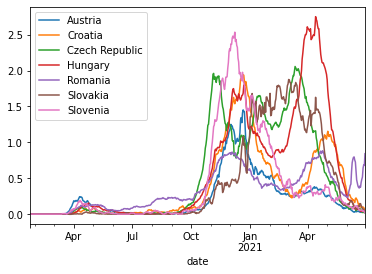

In [3]:
for i in df.index.levels[0]:
    (
        df
        .loc[i]
        .rename(columns={'daily_death_100k': i})
        [i]
        .iloc[1:]
        .rolling('7d').mean()
        .plot(legend=True)
    )


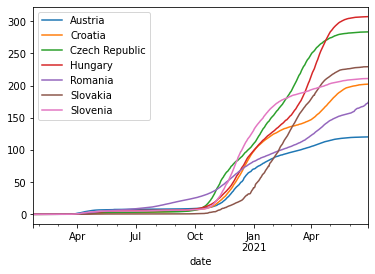

In [4]:
for i in df.index.levels[0]:
    (
        df
        .loc[i]
        .rename(columns={'deaths_100k': i})
        [i]
        .plot(legend=True)
    )

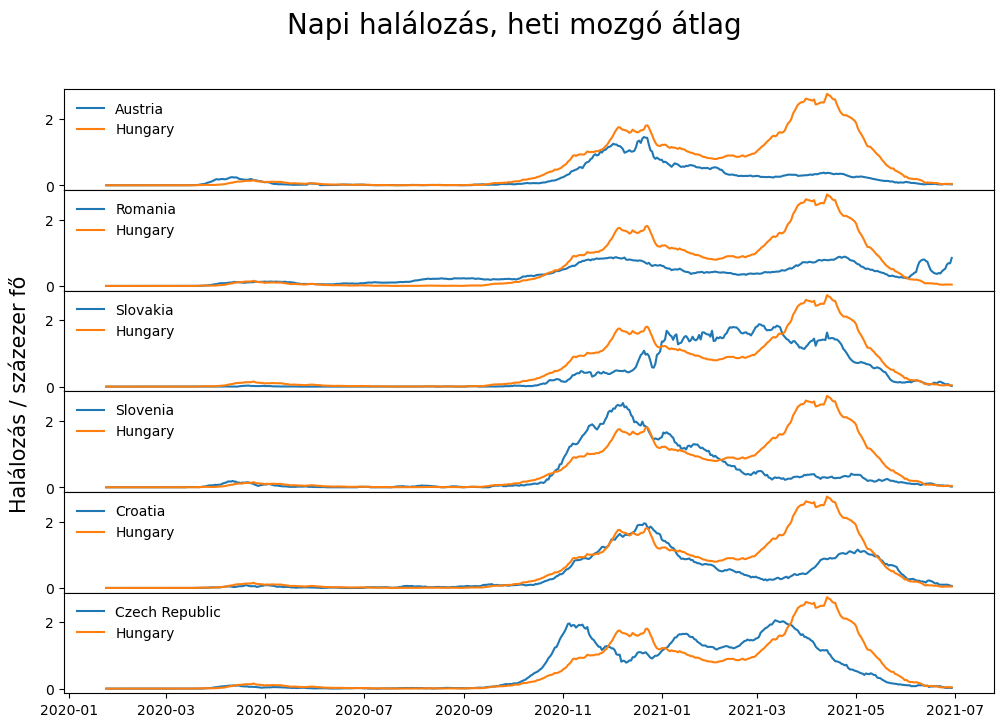

In [39]:
import matplotlib.pyplot as plt
import numpy as np


# Initialize plot:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
gs = fig.add_gridspec(6, hspace=0, ncols=1)
axs = gs.subplots(sharex=True, sharey=True)
fig.text(0.08, 0.5, 'Halálozás / százezer fő', va='center', rotation='vertical', fontsize=15)
fig.suptitle('Napi halálozás, heti mozgó átlag', fontsize=20)

i = 0
for country in countries:

    # Skipping Hungary:
    if country == 'Hungary':
        continue

    # Calculate rolling average for a country => plot:
    axs[i].plot(
        df
        .loc[country]
        .rename(columns={'daily_death_100k': country})
        [country]
        .iloc[1:]
        .rolling('7d').mean(),
        label=country
    )
    
    # Calculate rolling average for Hungary => plot
    axs[i].plot(
        df
        .loc['Hungary']
        .rename(columns={'daily_death_100k': 'Hungary'})
        ['Hungary']
        .iloc[1:]
        .rolling('7d').mean(),
        label='Hungary'
    )
    
    # Adding legend:
    axs[i].legend(loc='upper left', frameon=False)
    i += 1

plt.savefig('cicaful.png', dpi=100)

In [43]:
import matplotlib
matplotlib.__version__.split('.')[1] == '4'

True

In [65]:
country = 'United Kingdom'
country_pop_map = {'United Kingdom': 666.5}

df = (
    daily_covid_data
    
    # Filter for country 
    .loc[lambda df: df.Country == country]  
    .rename(columns={'Date': 'date', 'Deaths': 'deaths', 'Country': 'country', 'Confirmed': 'confirmed'})
    
    # A trick to move data from the previous row (has a side effect though as all countries are in one dataset):
    .assign(previous_day_death = lambda df: [0] + df.deaths.tolist()[:-1]) 
    .assign(previous_day_case = lambda df: [0] + df.confirmed.tolist()[:-1]) 
    
    
    # Calculate the number of death and case a given day:
    .assign(daily_death = lambda df: df.deaths - df.previous_day_death)
    .assign(daily_case = lambda df: df.confirmed - df.previous_day_case)

    # Daily death and case per 100k people:
    .assign(daily_death_100k = lambda df: df.daily_death / df.country.map(country_pop_map))
    .assign(daily_case_100k = lambda df: df.daily_case / df.country.map(country_pop_map))
    
    # Cumulative death per 100k people:
    .assign(deaths_100k = lambda df: df.deaths / 666.5)
    
    # Set date column as datetime object:
    .astype({'date': 'datetime64'})

    # Clean index and select columns:
    .reset_index()
    [['date', 'daily_death', 'daily_death_100k', 'daily_case', 'daily_case_100k']]
    
    .set_index('date')
)    



<AxesSubplot:xlabel='date'>

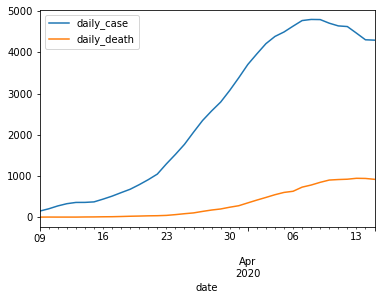

In [76]:
(
    df
    [['daily_case', 'daily_death']]
    .loc['2020-03-01':'2020-04-15']
    .loc[df.daily_case > 100]
#     .rename(columns={'daily_death_100k': 'daily_death', 'daily_case_100k': 'daily_case'})
    .rolling('7d').mean()
#     .assign(daily_death = lambda df: df.daily_death / df.daily_death.max())
#     .assign(daily_case = lambda df: df.daily_case / df.daily_case.max())
    .plot(legend=True)
)


<AxesSubplot:xlabel='date'>

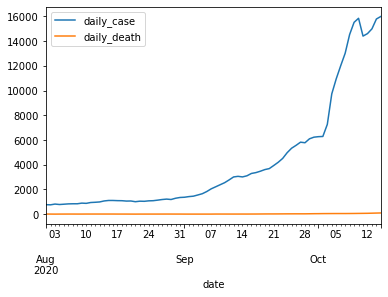

In [77]:
(
    df
    [['daily_case', 'daily_death']]
    .loc['2020-08-01':'2020-10-15']
    .loc[df.daily_case > 100]
    .loc[df.daily_case > 100]
#     .rename(columns={'daily_death_100k': 'daily_death', 'daily_case_100k': 'daily_case'})
    .rolling('7d').mean()
#     .assign(daily_death = lambda df: df.daily_death / df.daily_death.max())
#     .assign(daily_case = lambda df: df.daily_case / df.daily_case.max())
    .plot(legend=True)
)


